In [1]:
import torch 
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, utils
from skimage import io, transform
import sklearn
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import torch.optim as optim

%matplotlib inline

## Testing on the Pistacio_Image_Dataset

### Dataset

In [2]:

class CustomDataset(Dataset):
    def __init__(self, preprocess_transforms=None):
        
        base_dir = os.path.dirname(os.path.abspath(__name__))
        image_dir = os.path.join("Pistachio_Image_Dataset", "Pistachio_Image_Dataset")
        
        class_translation = {0: "Kirmizi", 1: "siirt"}
        class_dir_names = {0: "Kirmizi_Pistachio", 1: "Siirt_Pistachio"}
        
        kirmizi_abs_files = [os.path.join(image_dir, class_dir_names[0], file) for file in os.listdir(os.path.join(image_dir, class_dir_names[0]))]
        siirt_abs_files = [os.path.join(image_dir, class_dir_names[1], file) for file in os.listdir(os.path.join(image_dir, class_dir_names[1]))]

        self.image_files = kirmizi_abs_files + siirt_abs_files
        self.classes = np.full(len(kirmizi_abs_files), 0).tolist() + np.full(len(siirt_abs_files), 1).tolist()
        self.preprocess_transforms = preprocess_transforms

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_files[idx]
        img_class = self.classes[idx]
        
        image = cv2.imread(img_path)
        sample = {"image": image, "class": img_class}

        if self.preprocess_transforms is not None:
            sample = self.preprocess_transforms(sample)

        return sample
        
base_ds = CustomDataset()

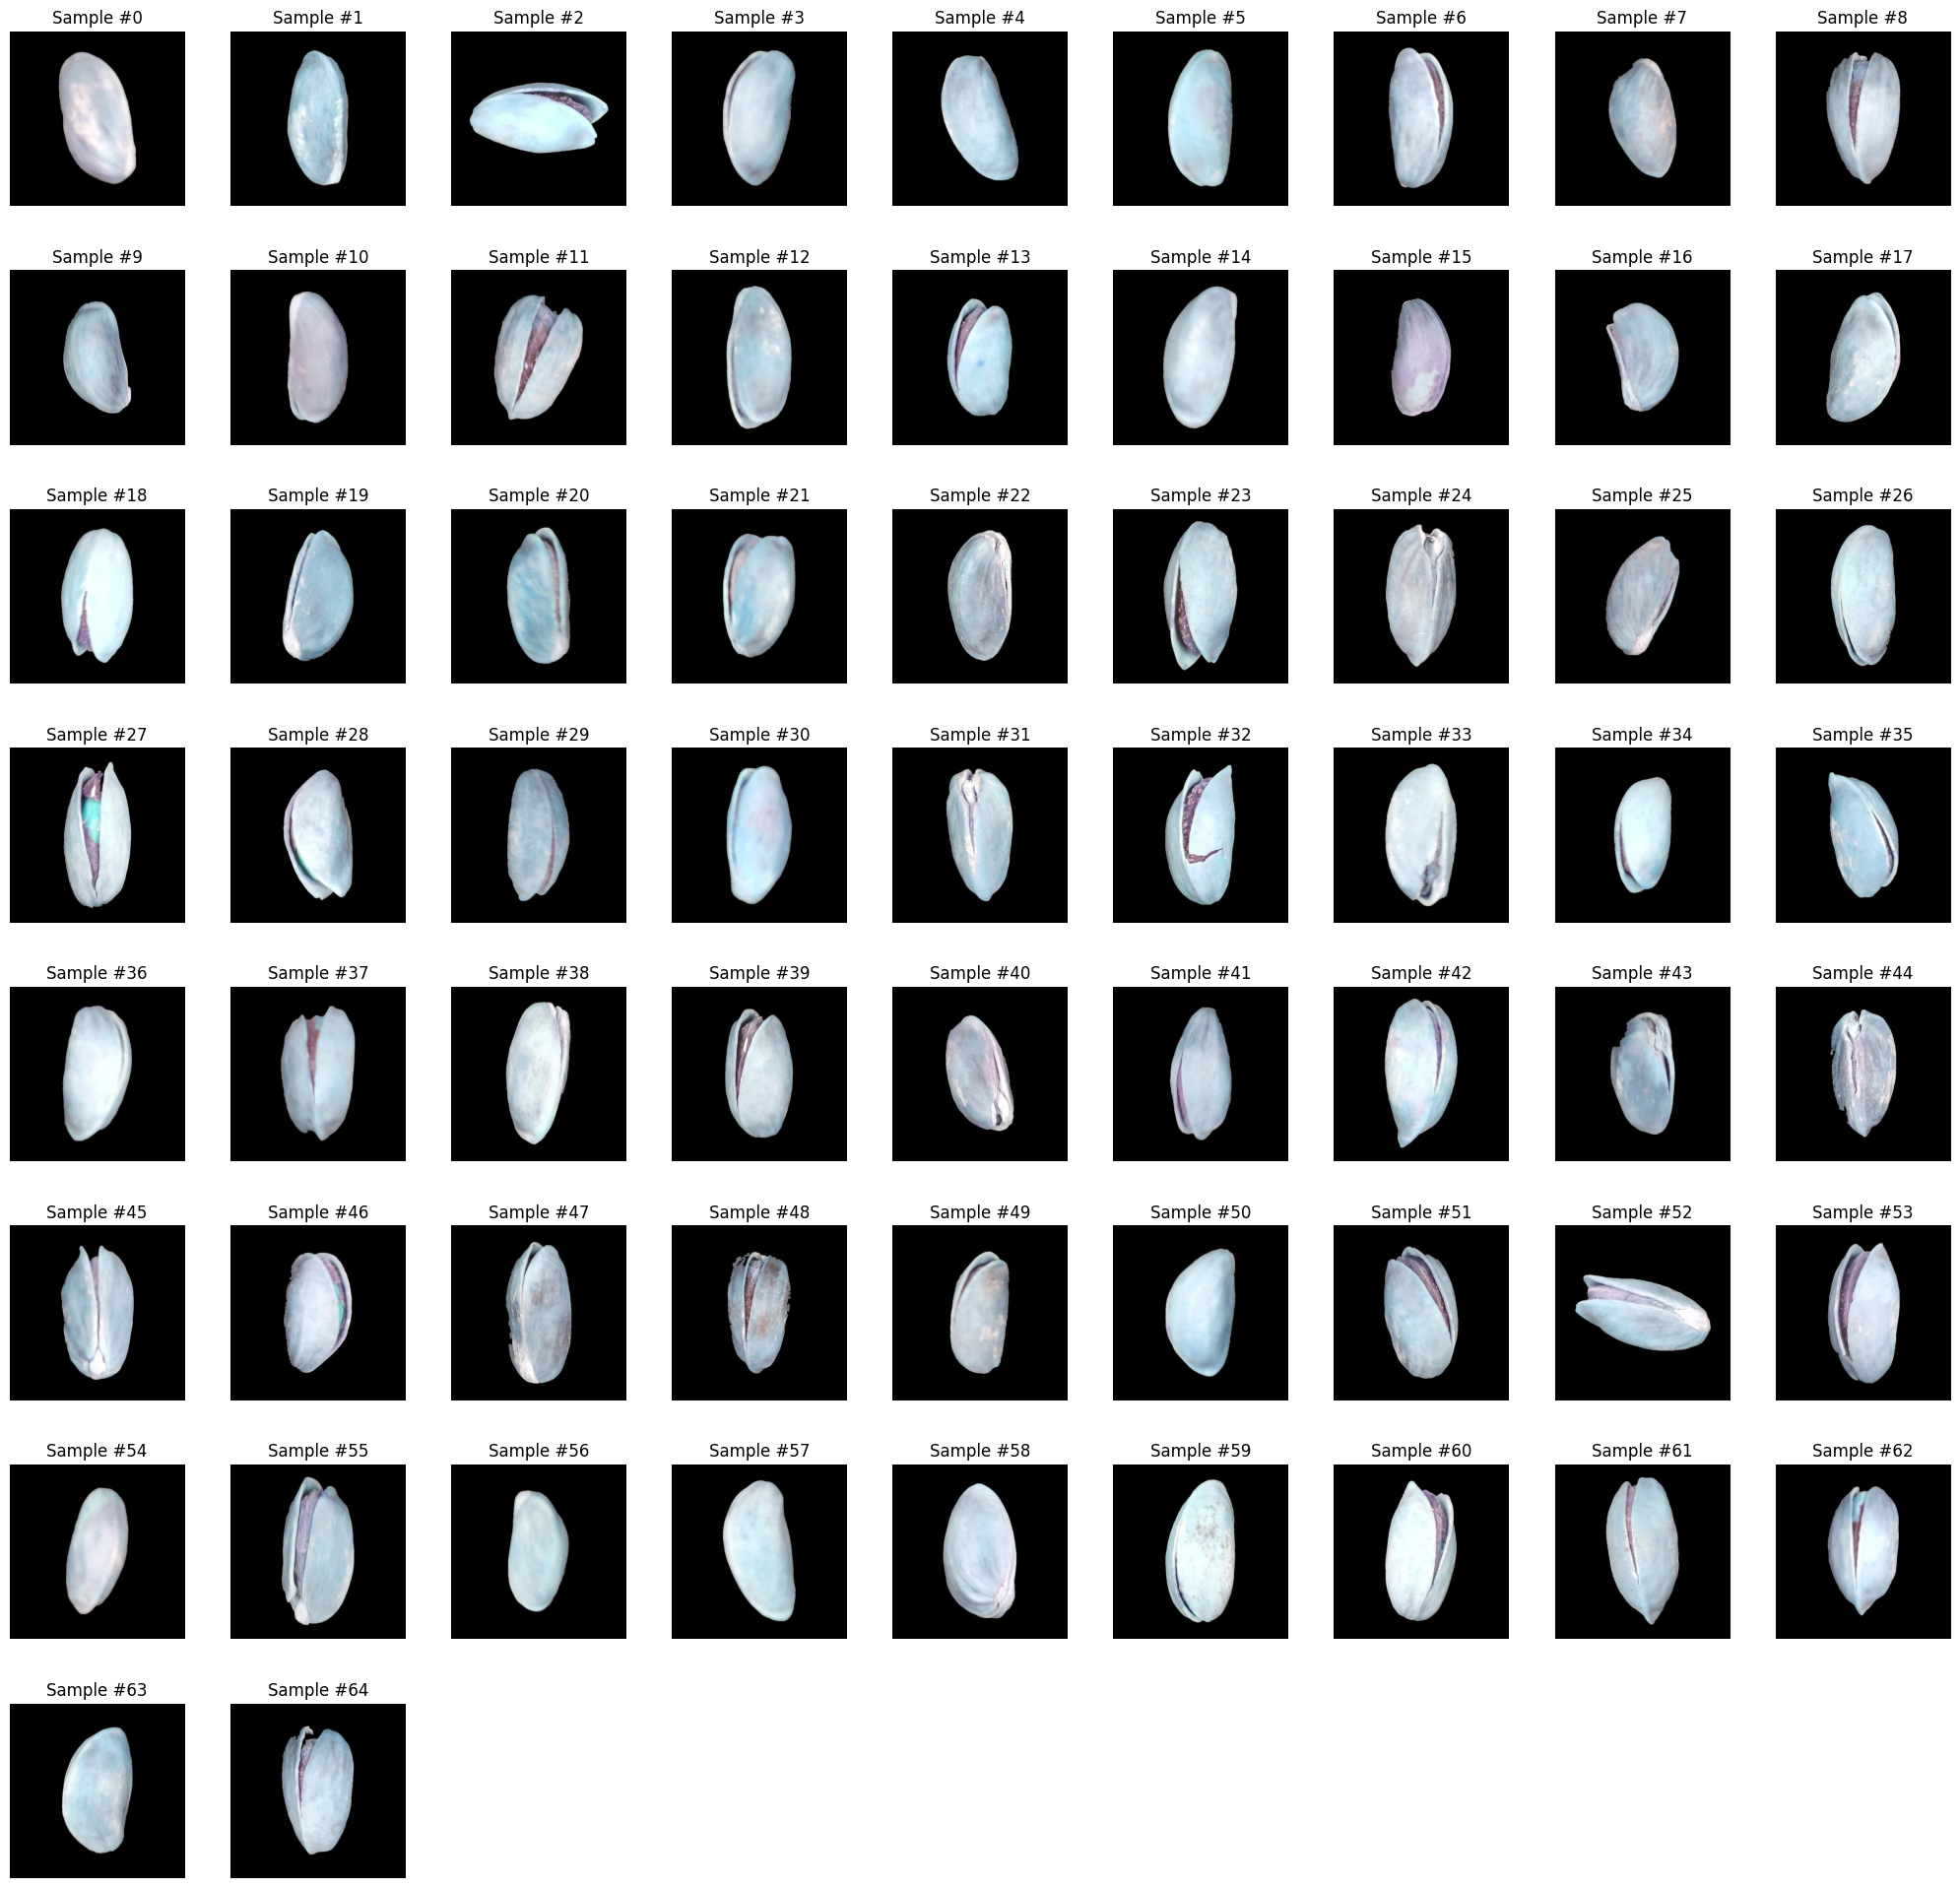

In [3]:
# View a few samples from the dataset

n_show = 64
fig = plt.figure(figsize=[20, 20])

for i, sample in enumerate(base_ds):
    ax = plt.subplot(8, n_show//8 + 1, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample["image"])
    if i == n_show:
        plt.show()
        break

# Preprocessing

In [4]:

class Normalize(object):
    "Normalizes the image to a std of 1 and mean of 0 (L2 Norm)"

    def __call__(self, sample):
        image = sample["image"]

        image_norm = (image - np.mean(image)) / np.std(image)

        sample["image"] = image_norm
        
        return sample


class Rescale():
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, img_class = sample['image'], sample['class']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
    
        return {'image': img, 'class': img_class}


class RandomCrop():
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, img_class = sample['image'], sample['class']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'class': img_class}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, img_class = sample['image'], sample['class']
      

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'class': torch.tensor(img_class, dtype=torch.int32)}



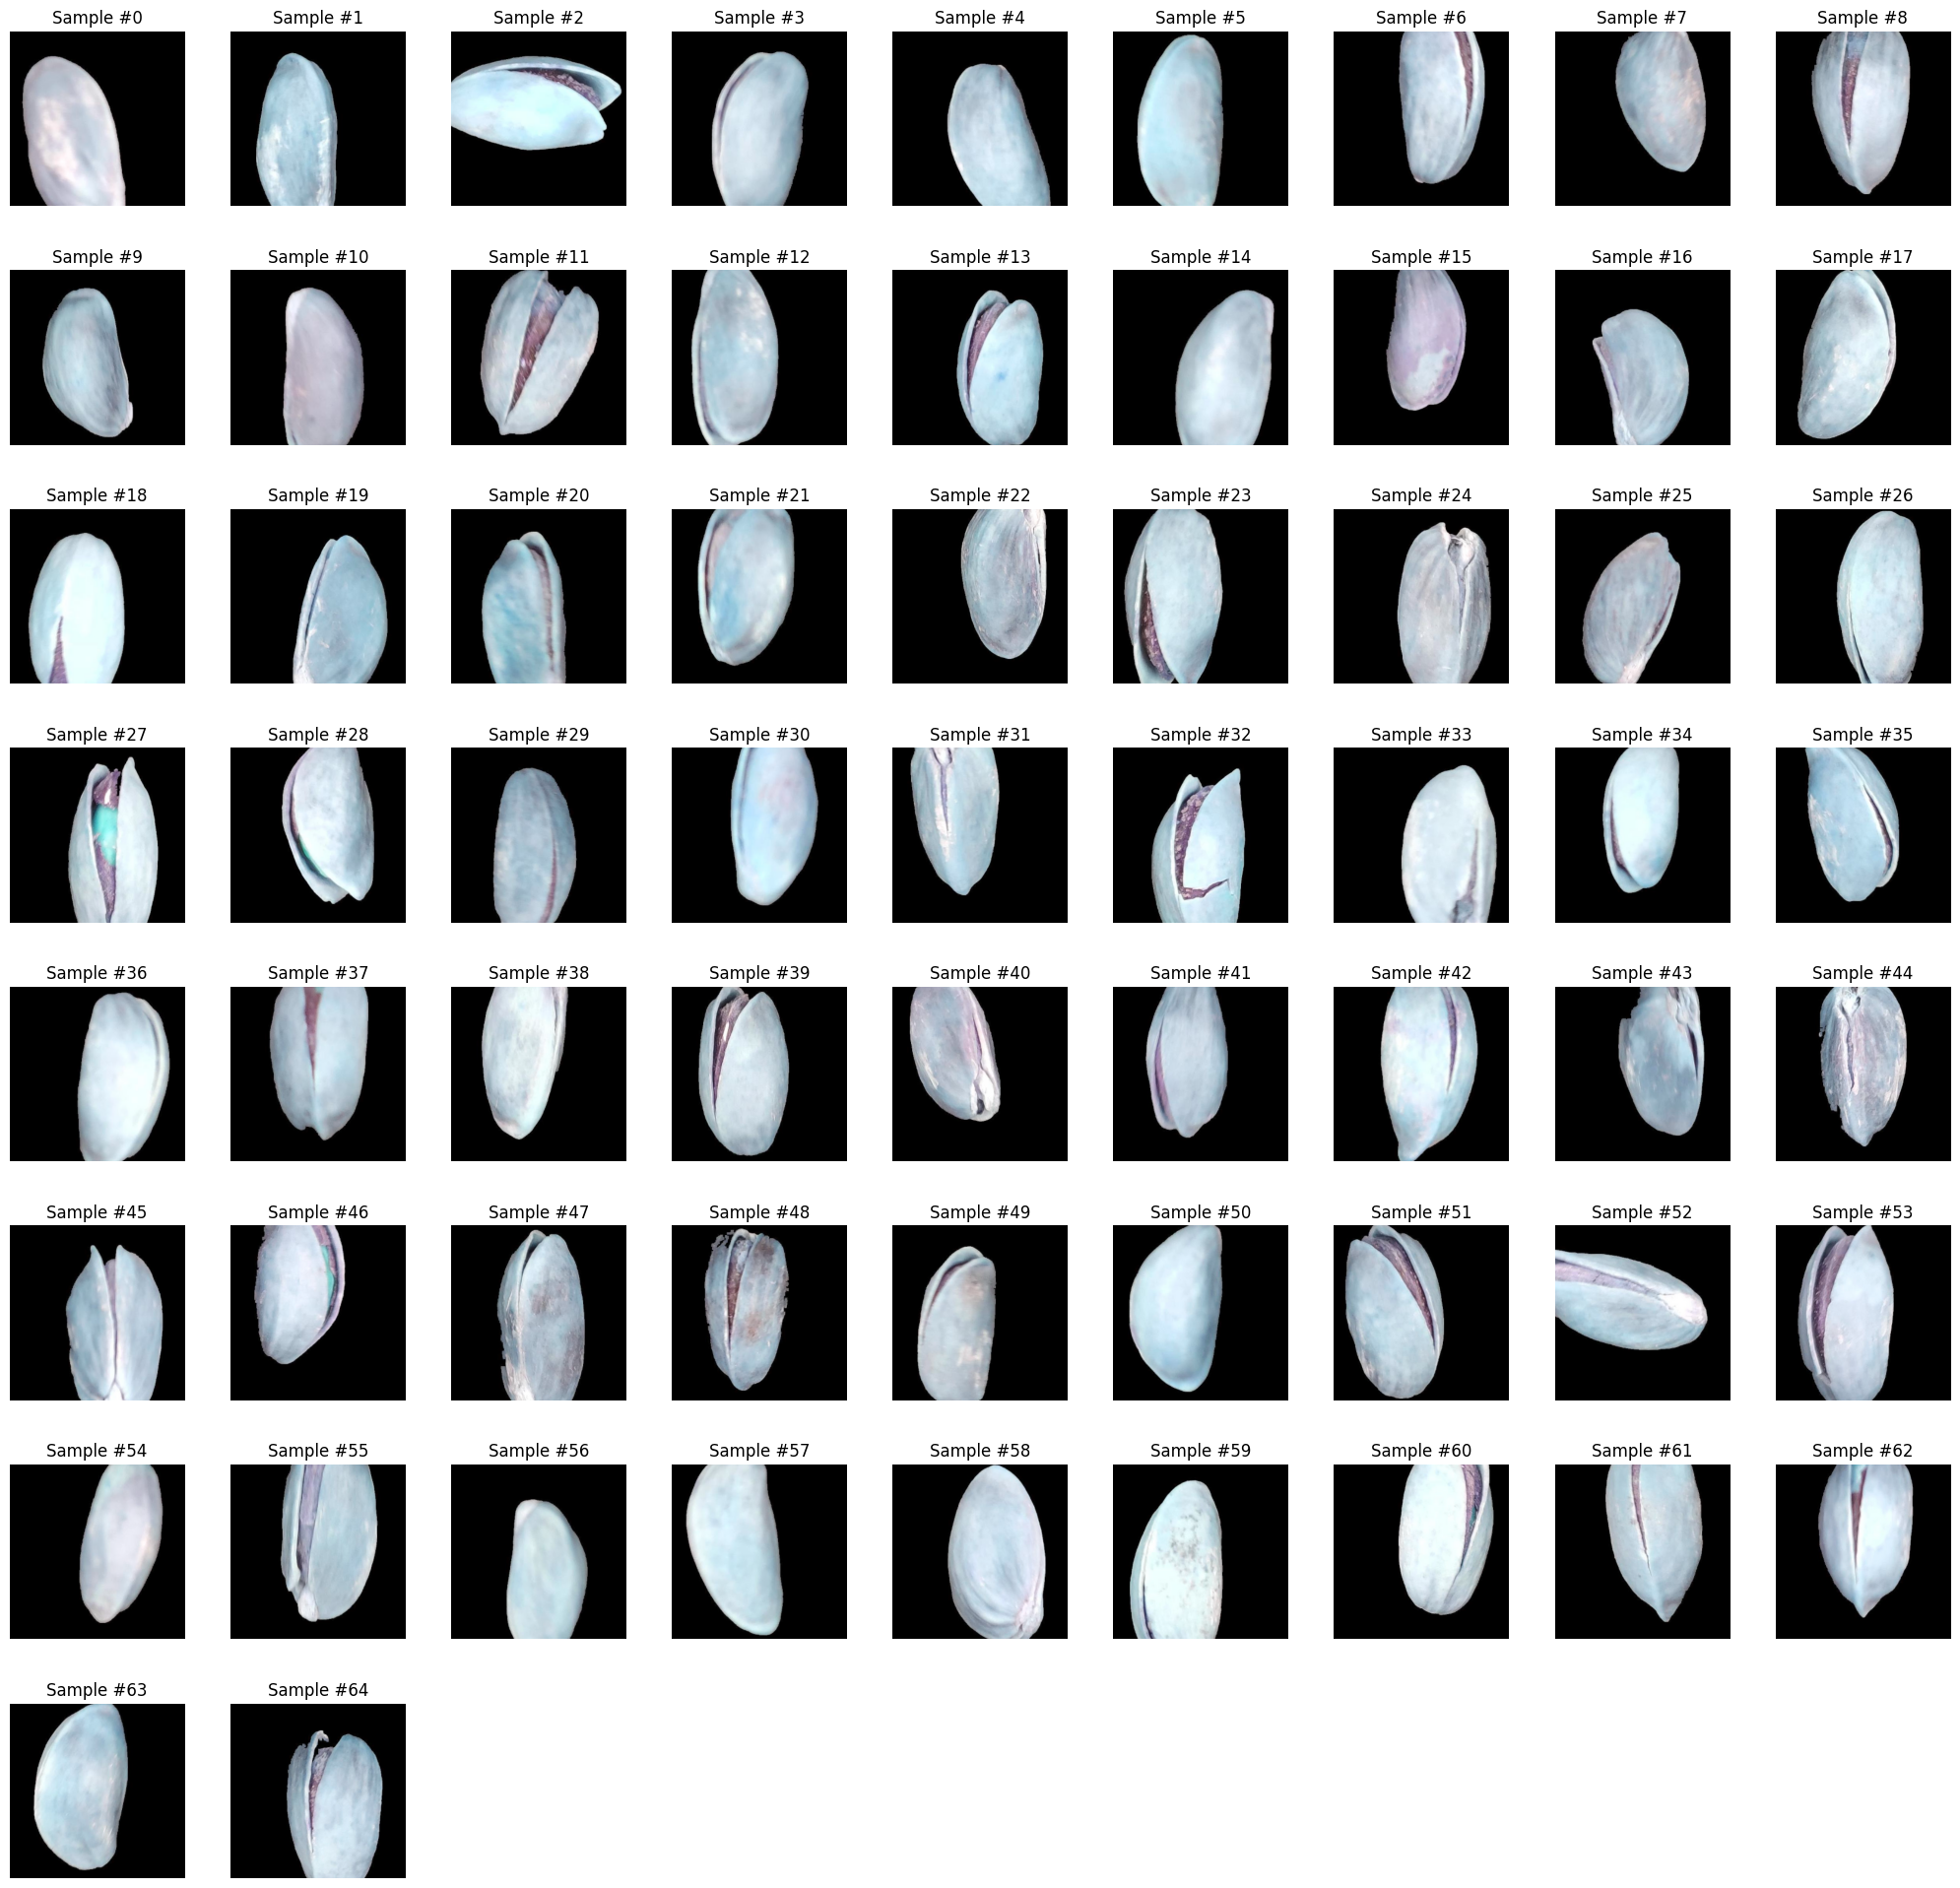

In [5]:
# Composing the transformations

scale = Rescale((400, 400))
crop = RandomCrop((300, 300))
norm = Normalize()
to_tensor = ToTensor()

test_transforms = transforms.Compose([scale, crop])
full_transforms = transforms.Compose([scale, crop, norm, to_tensor])

# View a few samples from the dataset

n_show = 64
fig = plt.figure(figsize=[20, 20])

for i, sample in enumerate(base_ds):
    sample = test_transforms(sample)
    ax = plt.subplot(8, n_show//8 + 1, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample["image"])
    if i == n_show:
        plt.show()
        break

In [19]:
# Dataset with Transforms
preprocessed_dataset = CustomDataset(preprocess_transforms=full_transforms)

# Splittign and shuffeling the Dataset
train_ds, val_ds, test_ds = random_split(dataset=preprocessed_dataset, lengths=[0.7, .2, .1])
val_ds.preprocess_transforms = transforms.Compose([Rescale((300, 300)),  norm, to_tensor])
test_ds.preprocess_transforms = transforms.Compose([Rescale((300, 300)), norm, to_tensor])


# Building the Dataloader

In [20]:
train_loader = DataLoader(train_ds, batch_size=64,  shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64,  shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64,  shuffle=True)

In [21]:
for batch in train_loader:
    print(batch.keys())
    print(batch["class"].shape, batch["image"].shape)
    print(batch["class"])
    break

dict_keys(['image', 'class'])
torch.Size([64]) torch.Size([64, 3, 300, 300])
tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0], dtype=torch.int32)


# Building the CNN

In [22]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

model.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)


Using cache found in /home/worker/.cache/torch/hub/pytorch_vision_v0.10.0
/mnt/Lukas/Übung/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/Lukas/Übung/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    #model = torch.compile(model)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(train_loader):
            #print("Batch: ", i, end="\r")
            images = batch['image'].to(device).float()
            labels = batch['class'].to(device).long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device).float()
                labels = batch['class'].to(device).long()
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}")


In [ ]:
train_model(model, train_loader, val_loader, epochs=1)

In [30]:
def test_model(model, test_loader):
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    #model = torch.compile(model)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        running_loss = 0.0
        for batch in test_loader:
            images = batch['image'].to(device).float()
            labels = batch['class'].to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    test_acc = correct / total
    loss = running_loss / len(test_loader.dataset)
    print(f"Loss: {loss:.4f}, Test Acc: {test_acc:.4f}")

In [ ]:
test_model(model, test_loader)